In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn import datasets, linear_model, neural_network,svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, RepeatedKFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import warnings; warnings.simplefilter('ignore')

In [2]:
# Import data form .csv file
csv_path = '/Users/amei/Desktop/project'
train= pd.read_csv(csv_path+'/historical_data.csv')

## Data pre-processing

In [3]:
# Rename
train = train.rename(columns={"market_id": "mkt_id",
                            "created_at": "create", 
                            "actual_delivery_time": "delivery", 
                            "store_primary_category": "store"})
# Convert data type
train['create'] = pd.to_datetime(train['create'])
train['delivery'] = pd.to_datetime(train['delivery'])

In [4]:
# General data cleaning
print(f'Total number of NA in the dataset\n{train.isna().sum()}')
train.dropna(inplace=True)
train.describe().transpose()

Total number of NA in the dataset
mkt_id                                            987
create                                              0
delivery                                            7
store_id                                            0
store                                            4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


,count,mean,std,min,25%,50%,75%,max
mkt_id,175777.0,2.743726,1.330963,1.0,2.0,2.0,4.0,6.0
store_id,175777.0,3556.299561,2055.959006,1.0,1703.0,3620.0,5341.0,6987.0
order_protocol,175777.0,2.911752,1.513128,1.0,1.0,3.0,4.0,7.0
total_items,175777.0,3.204976,2.674055,1.0,2.0,3.0,4.0,411.0
subtotal,175777.0,2697.111147,1828.554893,0.0,1412.0,2224.0,3410.0,26800.0
num_distinct_items,175777.0,2.675060,1.625681,1.0,1.0,2.0,3.0,20.0
min_item_price,175777.0,684.965433,519.882924,-86.0,299.0,595.0,942.0,14700.0
max_item_price,175777.0,1160.158616,560.828571,0.0,799.0,1095.0,1395.0,14700.0
total_onshift_dashers,175777.0,44.918664,34.544724,-4.0,17.0,37.0,66.0,171.0
total_busy_dashers,175777.0,41.861381,32.168505,-5.0,15.0,35.0,63.0,154.0


In [5]:
## Drop anomalies
keep_items = ((train.total_items > 0)|
              (train.min_item_price > 0)|
              (train.subtotal > 0)|
              (train.total_onshift_dashers > 0)|
              (train.total_busy_dashers > 0)|
              (train.total_outstanding_orders > 0)|
              (train.estimated_order_place_duration > 0)|
              (train.estimated_store_to_consumer_driving_duration > 0))
train = train[keep_items]

In [6]:
## Add feature
duration = train['delivery'] - train['create']
train['duration'] = duration / np.timedelta64(1, 's')
keep_duration = ((train.duration>60) & (train.duration<3600*2))
train = train[keep_duration]
print(f'Anomalies in total duration: {train[~keep_duration].shape[0] / train.shape[0] * 100:.2f}')
print(f'Total duration in seconds: {train.duration.min()} to {train.duration.max()}')
print(f'Zero item trips: {train[train.total_items == 0].shape[0]}')

Anomalies in total duration: 0.00
Total duration in seconds: 101.0 to 7196.0
Zero item trips: 0


## Feature Analysis

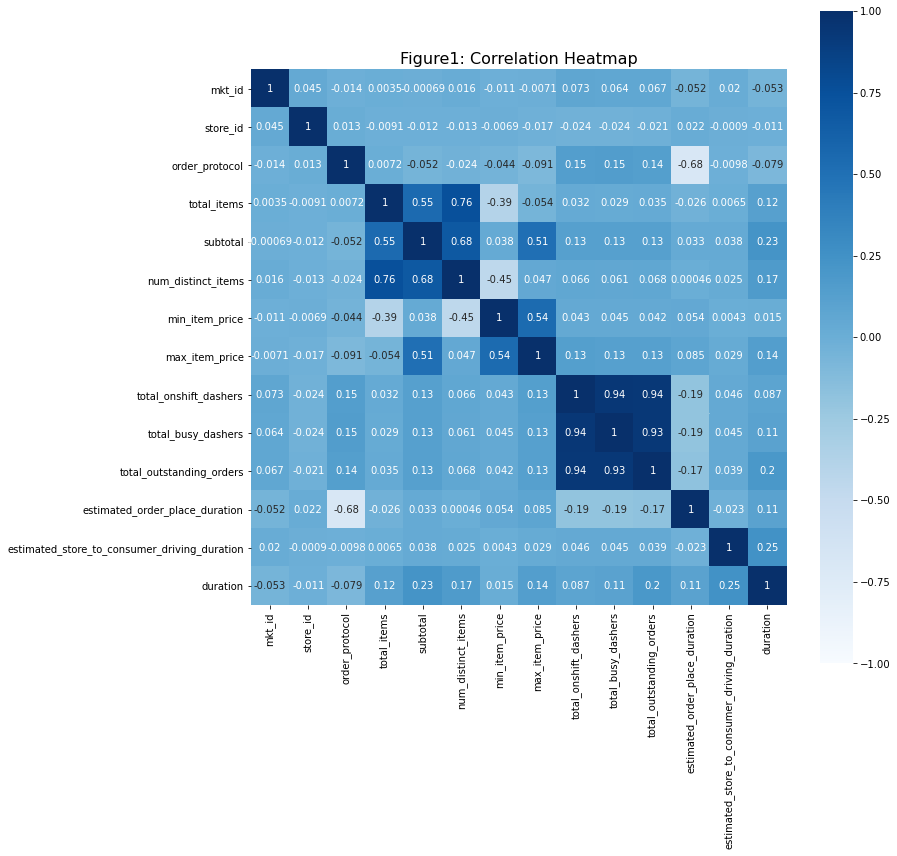

In [7]:
## Feature pre-analysis
# Correlation and heatmap

corr = train.corr()
corr.sort_values(by='duration', ascending=True)

plt.figure(figsize=(12,12))
sns.heatmap(corr,cmap='Blues',annot=True,vmin=-1,vmax=1,square=True)
plt.title("Figure1: Correlation Heatmap", fontsize=16) 
plt.show()

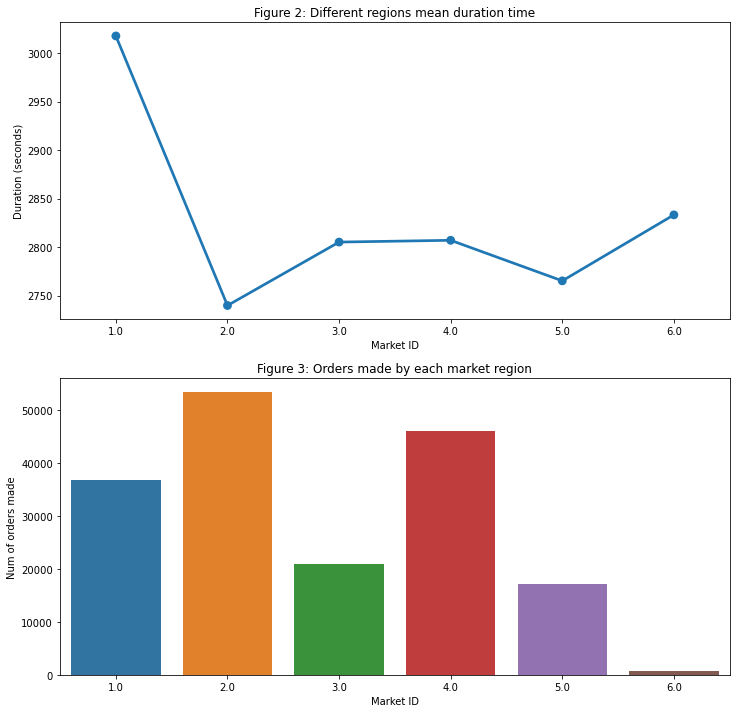

In [8]:
## Market ID analysis
mkt_train = train.filter(items=['mkt_id','duration'])
group1 = mkt_train.groupby('mkt_id').mean().reset_index()

plt.figure(figsize=(12,12))
plt.subplot(2, 1, 1)
sns.pointplot(x='mkt_id', y='duration', data=group1)
plt.title('Figure 2: Different regions mean duration time')
plt.ylabel('Duration (seconds)')
plt.xlabel('Market ID')

plt.subplot(2, 1, 2)
sns.countplot(x='mkt_id',data=mkt_train)
plt.title('Figure 3: Orders made by each market region')
plt.xlabel('Market ID')
plt.ylabel('Num of orders made')
plt.show()

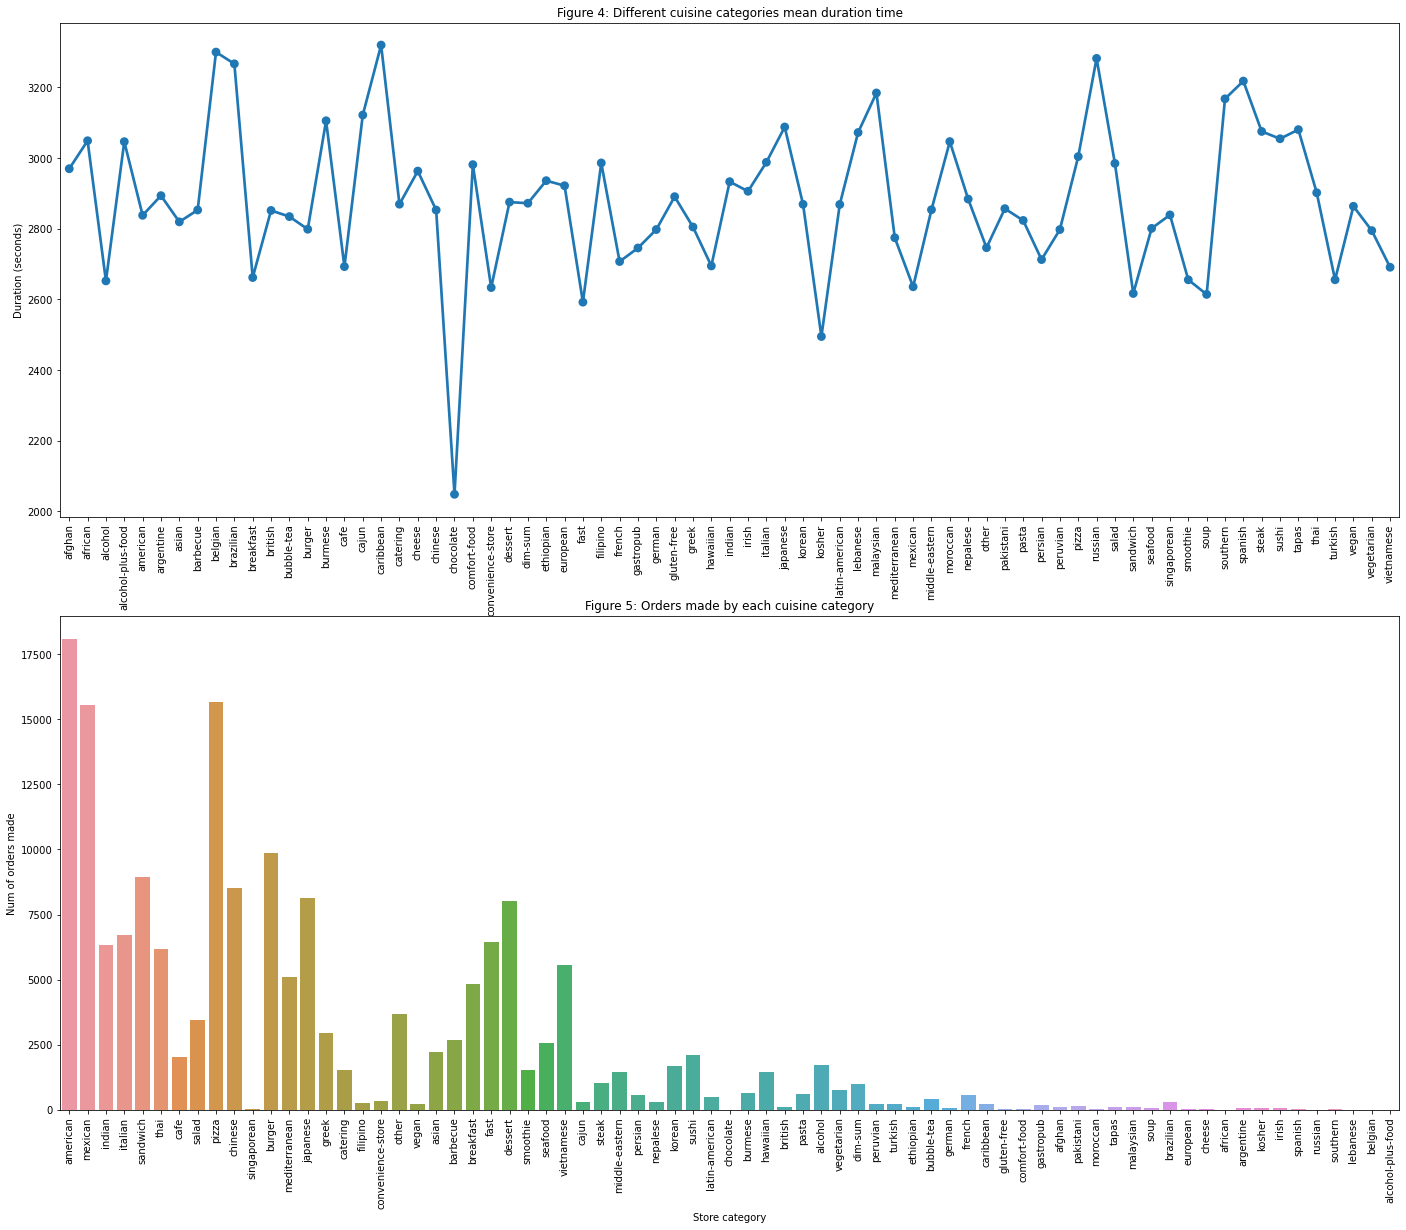

Top 5 store categories:
                0        1        2                  3         4
store      afghan  african  alcohol  alcohol-plus-food  american
duration  2969.43   3048.6  2651.98               3046    2837.6


In [9]:
## Store category analysis
store_train = train.filter(items=['store','duration'])
group1 = store_train.groupby('store').mean().reset_index()

plt.figure(figsize=(24,20))
plt.subplot(2, 1, 1)
ax=sns.pointplot(x='store', y='duration', data=group1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Figure 4: Different cuisine categories mean duration time')
plt.ylabel('Duration (seconds)')
plt.xlabel('Store category')

plt.subplot(2, 1, 2)
ax=sns.countplot(x='store',data=store_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Figure 5: Orders made by each cuisine category')
plt.xlabel('Store category')
plt.ylabel('Num of orders made')
plt.show()

print(f'Top 5 store categories:\n{group1[:5].transpose()}')

In [10]:
## Date, time analysis
date_train = train.filter(items=['create','delivery','duration'])
date_train['create_m'] = date_train.create.dt.month
date_train['create_w'] = date_train.create.dt.weekday
date_train['create_h'] = date_train.create.dt.hour

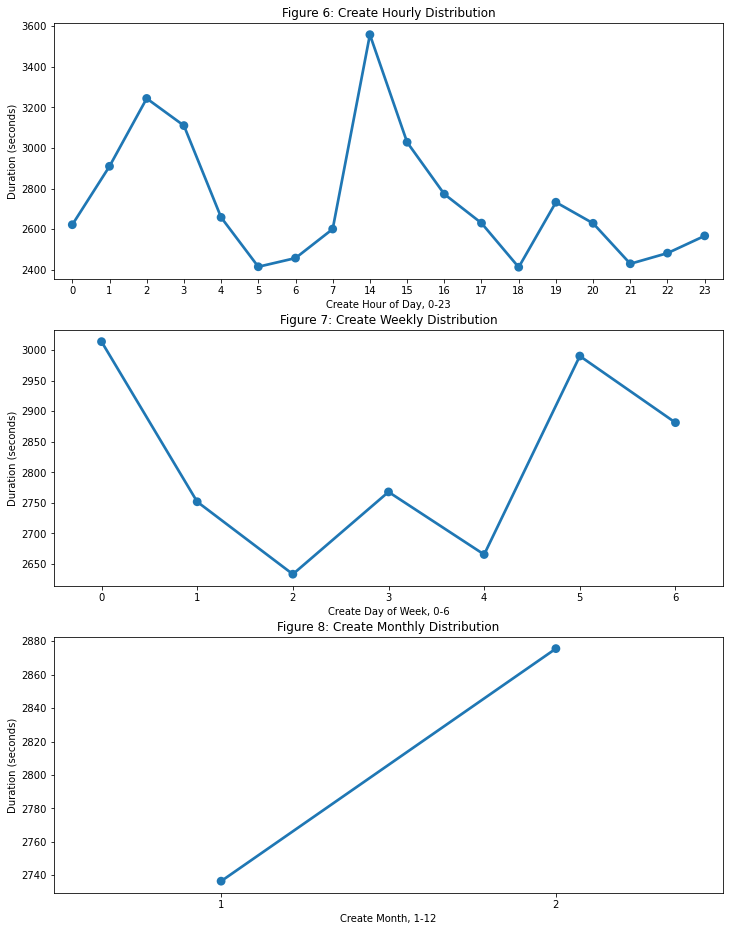

In [11]:
# Duration vs Time Distribution
plt.figure(figsize=(12,16))

plt.subplot(3, 1, 1)
group1 = date_train.groupby('create_h').mean().reset_index()
sns.pointplot(x='create_h', y='duration', data=group1)
plt.title('Figure 6: Create Hourly Distribution')
plt.ylabel('Duration (seconds)')
plt.xlabel('Create Hour of Day, 0-23')

plt.subplot(3, 1, 2)
group2 = date_train.groupby('create_w').mean().reset_index()
sns.pointplot(x='create_w', y='duration', data=group2)
plt.title('Figure 7: Create Weekly Distribution')
plt.ylabel('Duration (seconds)')
plt.xlabel('Create Day of Week, 0-6')

plt.subplot(3, 1, 3)
group3 = date_train.groupby('create_m').mean().reset_index()
sns.pointplot(x='create_m', y='duration', data=group3)
plt.title('Figure 8: Create Monthly Distribution')
plt.ylabel('Duration (seconds)')
plt.xlabel('Create Month, 1-12')

plt.show()

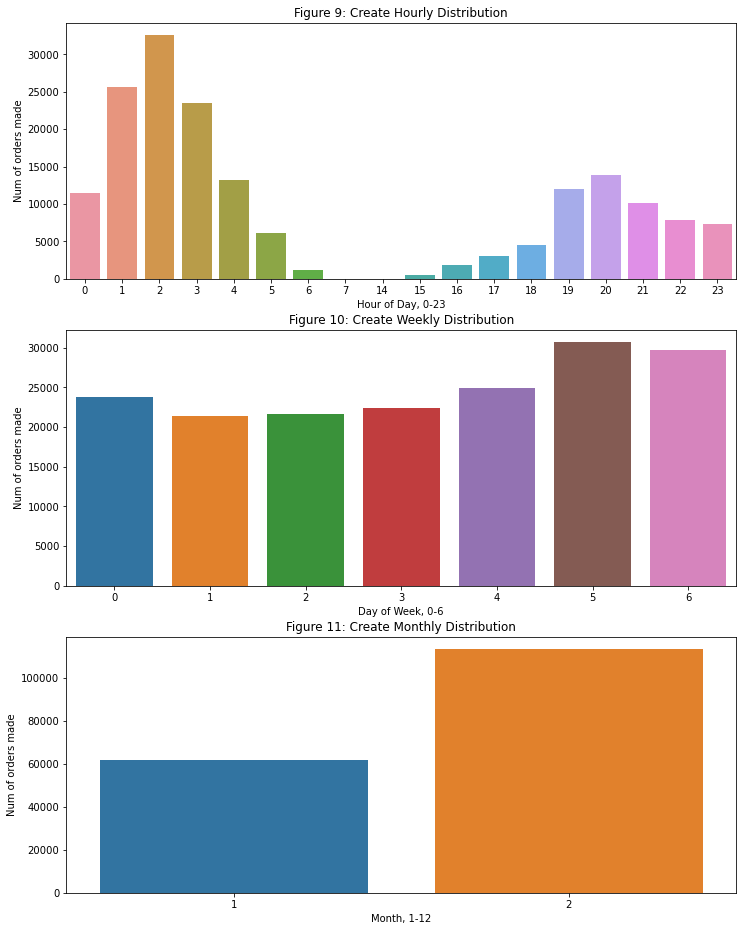

In [12]:
# Number of Orders vs Time Distribution
plt.figure(figsize=(12,16))

plt.subplot(3, 1, 1)
sns.countplot(x='create_h',data=date_train)
plt.title('Figure 9: Create Hourly Distribution')
plt.xlabel('Hour of Day, 0-23')
plt.ylabel('Num of orders made')

plt.subplot(3, 1, 2)
sns.countplot(x='create_w',data=date_train)
plt.title('Figure 10: Create Weekly Distribution')
plt.xlabel('Day of Week, 0-6')
plt.ylabel('Num of orders made')

plt.subplot(3, 1, 3)
sns.countplot(x='create_m',data=date_train)
plt.title('Figure 11: Create Monthly Distribution')
plt.xlabel('Month, 1-12')
plt.ylabel('Num of orders made')

plt.show()

In [13]:
## pre-modeling: ready to select model
# One-hot encoding
mkt_id = pd.get_dummies(train['mkt_id'], prefix='mkt')
store = pd.get_dummies(train['store'], prefix='store')
create_h = pd.get_dummies(date_train['create_h'], prefix='create_h')
create_w = pd.get_dummies(date_train['create_w'], prefix='create_w')
create_m = pd.get_dummies(date_train['create_m'], prefix='create_m')
train_new = pd.concat([train,mkt_id,store,create_h,create_w,create_m],axis=1)
train_new.drop(columns=['mkt_id','store','create','delivery'], inplace=True)
# split data
Y = train_new['duration']
X = train_new.drop(columns=['duration'])

In [14]:
## Split raw data
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state=72, test_size=0.2) 

In [15]:
## Feature selection
X_fs = X.copy()
p_value = np.ones(2)*np.Inf
while max(p_value)>0.05:
    regressor_OLS = sm.OLS(endog = Y, exog = X_fs).fit()
    p_value = regressor_OLS.pvalues
    X_fs.drop(columns=[p_value.index[np.argmax(p_value)]],inplace=True)
    print(f'drop: {p_value.index[np.argmax(p_value)]}')

regressor_OLS.summary()
# split data
x_train_fs, x_test_fs, y_train_fs, y_test_fs = train_test_split(X_fs,Y, random_state=72, test_size=0.2)

drop: store_gluten-free
drop: store_italian
drop: store_dim-sum
drop: store_african
drop: store_ethiopian
drop: store_lebanese
drop: store_european
drop: store_chocolate
drop: store_asian
drop: store_british
drop: create_h_23
drop: create_h_7
drop: store_chinese
drop: store_alcohol-plus-food
drop: min_item_price
drop: store_irish
drop: order_protocol
drop: store_spanish
drop: store_afghan
drop: create_h_17
drop: store_catering
drop: store_kosher
drop: store_mediterranean
drop: store_sandwich
drop: store_greek
drop: store_smoothie
drop: store_malaysian
drop: store_pasta
drop: store_comfort-food
drop: store_cheese
drop: store_vegetarian
drop: store_belgian
drop: store_latin-american
drop: store_korean
drop: store_russian
drop: store_sushi
drop: store_german
drop: store_steak
drop: store_argentine
drop: store_southern
drop: store_other
drop: store_american
drop: store_middle-eastern
drop: store_cajun
drop: store_singaporean
drop: store_filipino


## Model selection


In [16]:
# DIY functions
def print_results(x_train,y_train,x_test,y_test,y_pd,reg):

    fig,ax=plt.subplots()
    ax.plot(y_test,y_pd,'.')
    line = np.linspace(*ax.get_xlim())
    ax.plot(line, line)
    ax.set(xlabel='Test label',ylabel='Predict label',title='Test label vs Predict label')
    ax.grid()
    
    plt.show()
    
    score_train = reg.score(x_train, y_train)*100
    score_test = reg.score(x_test, y_test)*100
    MSE = mean_squared_error(y_test, y_pd)
    MAE = mean_absolute_error(y_test, y_pd)
    print(f'Train score: {score_train:.2f}, Test score: {score_test:.2f}')
    print(f'MSE:{MSE:.4f}, MAE:{MAE:.4f}')
    
    print('-'*50)

In [17]:
# Linear regression model
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
y_pd = reg.predict(x_test)

reg_fs = linear_model.LinearRegression()
reg_fs.fit(x_train_fs, y_train_fs)
y_pd_fs = reg_fs.predict(x_test_fs)

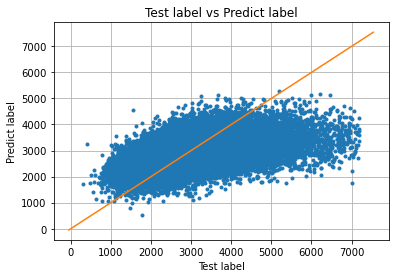

Train score: 30.17, Test score: 29.44
MSE:735234.0972, MAE:652.6511
--------------------------------------------------


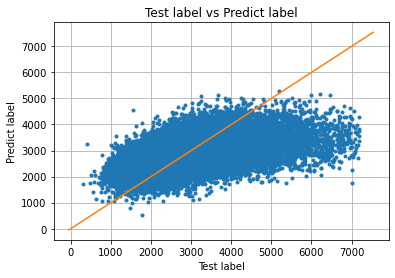

Train score: 30.15, Test score: 29.46
MSE:735035.0851, MAE:652.5742
--------------------------------------------------


In [18]:
print_results(x_train,y_train,x_test,y_test,y_pd,reg)
print_results(x_train_fs,y_train_fs,x_test_fs,y_test_fs,y_pd_fs,reg_fs)

In [19]:
# RF regression model
regr = RandomForestRegressor(n_estimators=20,n_jobs=-1)
regr.fit(x_train, y_train)
y_pd = regr.predict(x_test)

regr_fs = RandomForestRegressor(n_estimators=20,n_jobs=-1)
regr_fs.fit(x_train_fs, y_train_fs)
y_pd_fs = regr_fs.predict(x_test_fs)

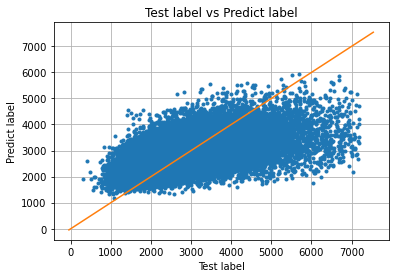

Train score: 89.23, Test score: 31.21
MSE:716846.4187, MAE:645.9624
--------------------------------------------------


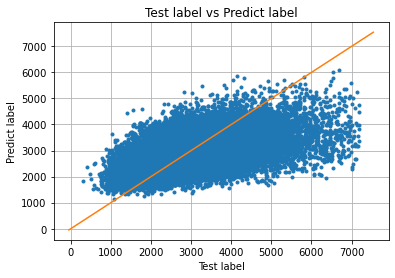

Train score: 89.16, Test score: 30.66
MSE:722546.7849, MAE:649.6150
--------------------------------------------------


In [20]:
print_results(x_train,y_train,x_test,y_test,y_pd,regr)
print_results(x_train_fs,y_train_fs,x_test_fs,y_test_fs,y_pd_fs,regr_fs)

In [21]:
regn = neural_network.MLPRegressor()
regn.fit(x_train, y_train)
y_pd = regn.predict(x_test)

regn_fs = neural_network.MLPRegressor()
regn_fs.fit(x_train_fs, y_train_fs)
y_pd_fs = regn_fs.predict(x_test_fs)

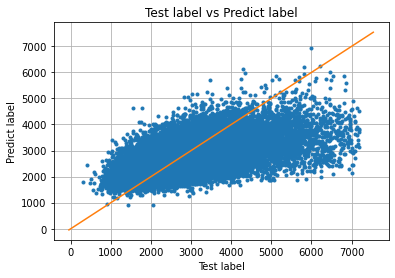

Train score: 35.25, Test score: 33.88
MSE:689041.1473, MAE:619.7764
--------------------------------------------------


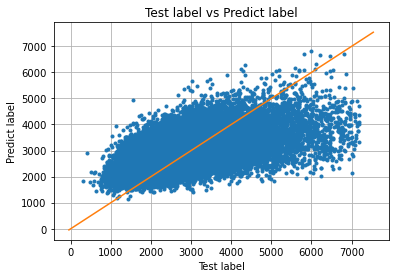

Train score: 33.11, Test score: 31.90
MSE:709608.3828, MAE:655.8328
--------------------------------------------------


In [22]:
print_results(x_train,y_train,x_test,y_test,y_pd,regn)
print_results(x_train_fs,y_train_fs,x_test_fs,y_test_fs,y_pd_fs,regn_fs)

In [23]:
def loc_feature(X,test_new):
    train_value_list = list(X.columns.values)
    test_value_list = list(test_new.columns.values)
    for x in train_value_list:
        if x in test_value_list:
            pass
        else:
            print('Add',x,train_value_list.index(x))
            test_new.insert(train_value_list.index(x), x, zeros)
    for x in test_value_list:
        if x in train_value_list:
            pass
        else:
            print('Remove',x,test_value_list.index(x))
            test_new.drop(columns=[x], inplace=True)

In [24]:
# Process test dataset
X = train_new.drop(columns=['duration'])
test = pd.read_csv(csv_path+'/predict_data.csv')
# using delivery id as index
test.set_index('delivery_id',inplace=True)
# re-apply changes
test = test.rename(columns={"market_id": "mkt_id",
                            "created_at": "create", 
                            "store_primary_category": "store"})
test['create'] = pd.to_datetime(test['create'])
keep_items = ((test.total_items > 0)|
              (test.min_item_price > 0)|
              (test.subtotal > 0)|
              (test.total_onshift_dashers > 0)|
              (test.total_busy_dashers > 0)|
              (test.total_outstanding_orders > 0)|
              (test.estimated_order_place_duration > 0)|
              (test.estimated_store_to_consumer_driving_duration > 0))
test = test[keep_items]
# additional features
date_test = test.filter(items=['create'])
date_test['create_m'] = date_test.create.dt.month
date_test['create_w'] = date_test.create.dt.weekday
date_test['create_h'] = date_test.create.dt.hour
mkt_id = pd.get_dummies(test['mkt_id'], prefix='mkt')
store = pd.get_dummies(test['store'], prefix='store')
create_h = pd.get_dummies(date_test['create_h'], prefix='create_h')
create_w = pd.get_dummies(date_test['create_w'], prefix='create_w')
create_m = pd.get_dummies(date_test['create_m'], prefix='create_m')
# add missing features
zeros=pd.DataFrame(np.zeros([test.shape[0],1]),columns=['zeros'])
test_new = pd.concat([test,mkt_id,store,create_h,create_w,create_m],axis=1)
# matching test and train dataset
loc_feature(X,test_new)
test_new.fillna(0,inplace=True)

Add store_belgian 26
Add store_chocolate 39
Add store_lebanese 61
Add create_m_1 116
Remove mkt_id 0
Remove create 1
Remove store 3
Remove platform 15
Remove store_indonesian 57


In [25]:
y_pd_new = regn.predict(test_new)
print(f'Min:{y_pd_new.min()}\nMax:{y_pd_new.max()}\nMean:{y_pd_new.mean()}')

Min:965.4992366711294
Max:6142.444342951624
Mean:2774.4789582295116


In [26]:
# create csv file
result = pd.read_csv(csv_path+'/predict_data.csv')
result['predict_duration'] = y_pd_new
result.to_csv(csv_path+'/predict_data_amei.csv')